# Anytrading Gym Examples
## Note: this uses the default anytrading gym, not the one locally found in `environment`.

In [55]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [3]:
env = gym.make('stocks-v0')

/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (30, 2)
  logger.warn(


In [34]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

google_env = gym.make('stocks-v0',
                      df=STOCKS_GOOGL,
                      window_size=100,  # this is how much many past data points to keep in the state
                      frame_bound=(100, 3000))  # 100 is how many data points we need to start in the state with

/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (100, 2)
  logger.warn(


In [52]:
# 0 is sell, 1 is buy.
google_env.action_space.sample()

0

/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_e

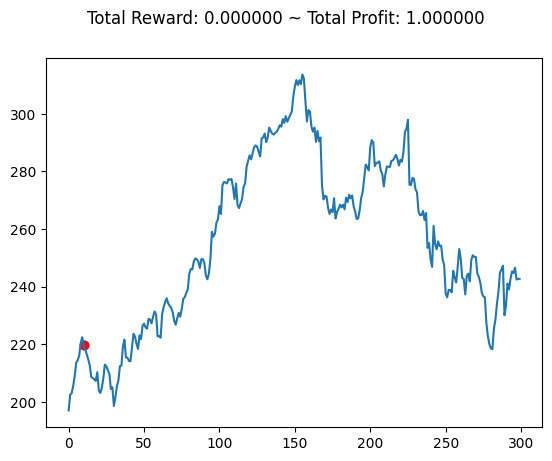

In [18]:
google_env.reset()
google_env.render()

In [56]:
def run(env: gym.Env) -> gym.Env:
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        print(f'{state} => {next_state} | reward = {reward}, info={info}')

    return env

    plt.cla()
    env.render_all()
    plt.show()

In [73]:
def run_with_policy(env: gym.Env, policy) -> gym.Env:
    state = env.reset()

    rewards = []

    done = False
    while not done:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)

    return env, rewards

In [ ]:
def always_buy_policy(state) -> gym.core.ActType:
    return 1

def always_sell_policy(state) -> gym.core.ActType:
    return 0

In [102]:
def moving_average_policy(state, short_horizon: int, long_horizon: int, lookback: int) -> gym.core.ActType:
    # When the short-term moving average rises above the long-term moving average, buy.
    # When the short-term moving average drops below the long-term moving average, sell.
    # Ensure that the state's window is at least the length of long_horizon + lookback.

    # State is a 2D array, with n rows and 2 columns. Each row represents [price, delta] where delta is the change
    # since the last price.
    assert len(state) >= max(short_horizon, long_horizon) + lookback

    # we need three points for each of the averages, to check they are crossing and in which direction.
    short_moving_avgs = [np.average(state[-short_horizon - lookback: -lookback]),
                         np.average(state[-short_horizon:])]
    long_moving_avgs = [np.average(state[-long_horizon - lookback: -lookback]),
                        np.average(state[-long_horizon:])]

    if short_moving_avgs[0] > long_moving_avgs[0] and short_moving_avgs[-1] < long_moving_avgs[-1]:
        print(f'{short_moving_avgs[0]} dropped below {long_moving_avgs[0]} => SELL')
        return 0  # short-term moving average drops below long-term moving average => sell
    elif short_moving_avgs[0] < long_moving_avgs[0] and short_moving_avgs[-1] > long_moving_avgs[-1]:
        print(f'{short_moving_avgs[0]} rose above {long_moving_avgs[0]} => BUY')
        return 1  # short-term moving average rises above long-term moving average => buy
    print(f'{short_moving_avgs[0]:.2f} vs. {long_moving_avgs[0]:.2f} | '
          f'{short_moving_avgs[-1]:.2f} vs. {long_moving_avgs[-1]:.2f}  => DEFAULT BUY')
    return 1

In [103]:
moving_avg_50_200 = lambda state: moving_average_policy(state, 50, 200, 5)
google_env = gym.make('stocks-v0',
                      df=STOCKS_GOOGL,
                      window_size=205,  # this is how much many past data points to keep in the state
                      frame_bound=(205, 3000))  # 100 is how many data points we need to start in the state with
env_end, rewards = run_with_policy(google_env, moving_avg_50_200)

140.32 vs. 127.67 | 138.94 vs. 128.61  => DEFAULT BUY
140.11 vs. 127.89 | 138.67 vs. 128.78  => DEFAULT BUY
139.92 vs. 128.10 | 138.47 vs. 128.93  => DEFAULT BUY
139.53 vs. 128.26 | 138.35 vs. 129.06  => DEFAULT BUY
139.28 vs. 128.44 | 138.00 vs. 129.17  => DEFAULT BUY
138.94 vs. 128.61 | 137.83 vs. 129.34  => DEFAULT BUY
138.67 vs. 128.78 | 137.77 vs. 129.51  => DEFAULT BUY
138.47 vs. 128.93 | 137.67 vs. 129.68  => DEFAULT BUY
138.35 vs. 129.06 | 137.51 vs. 129.85  => DEFAULT BUY
138.00 vs. 129.17 | 137.52 vs. 130.04  => DEFAULT BUY
137.83 vs. 129.34 | 137.38 vs. 130.23  => DEFAULT BUY
137.77 vs. 129.51 | 137.37 vs. 130.43  => DEFAULT BUY
137.67 vs. 129.68 | 137.30 vs. 130.63  => DEFAULT BUY
137.51 vs. 129.85 | 137.55 vs. 130.82  => DEFAULT BUY
137.52 vs. 130.04 | 137.69 vs. 130.98  => DEFAULT BUY
137.38 vs. 130.23 | 137.82 vs. 131.21  => DEFAULT BUY
137.37 vs. 130.43 | 137.94 vs. 131.41  => DEFAULT BUY
137.30 vs. 130.63 | 138.20 vs. 131.62  => DEFAULT BUY
137.55 vs. 130.82 | 138.58 v

/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (205, 2)
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/si

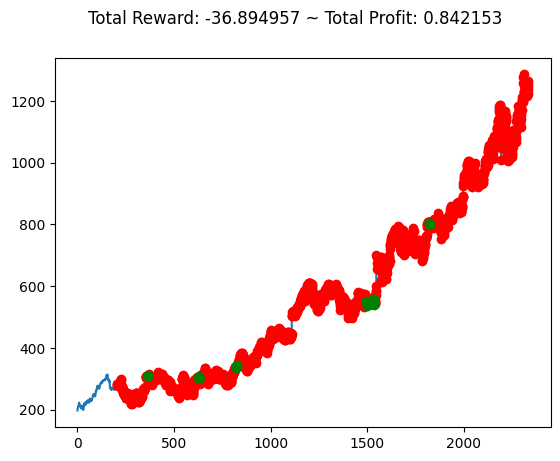

In [104]:
env_end.render_all()

/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (100, 2)
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/marc/opt/anaconda3/envs/rl/lib/python3.9/si

[[202.382385   5.43544 ]
 [202.982986   0.600601]
 [205.405411   2.422425]
 [208.823822   3.418411]
 [213.4935     4.669678]
 [214.414413   0.920913]
 [216.041046   1.626633]
 [220.360367   4.319321]
 [222.382385   2.022018]
 [219.604599  -2.777786]] => [[202.982986   0.600601]
 [205.405411   2.422425]
 [208.823822   3.418411]
 [213.4935     4.669678]
 [214.414413   0.920913]
 [216.041046   1.626633]
 [220.360367   4.319321]
 [222.382385   2.022018]
 [219.604599  -2.777786]
 [218.02803   -1.576569]] | reward = 0, info={'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
[[202.382385   5.43544 ]
 [202.982986   0.600601]
 [205.405411   2.422425]
 [208.823822   3.418411]
 [213.4935     4.669678]
 [214.414413   0.920913]
 [216.041046   1.626633]
 [220.360367   4.319321]
 [222.382385   2.022018]
 [219.604599  -2.777786]] => [[205.405411   2.422425]
 [208.823822   3.418411]
 [213.4935     4.669678]
 [214.414413   0.920913]
 [216.041046   1.626633]
 [220.360367   4.319321]
 [222.382385  

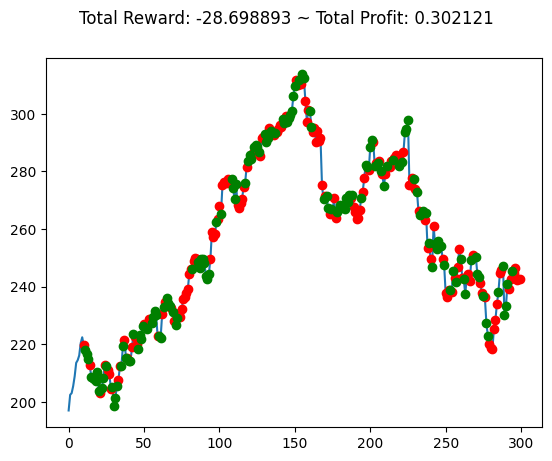

In [31]:
forex_env = gym.make('forex-v0',
                     df=FOREX_EURUSD_1H_ASK,
                     window_size=100,  # this is how much many past data points to keep in the state
                     frame_bound=(100, 3000),  # 100 is how many data points we need to start in the state with
                     unit_side='right')
run(google_env)